# Machine Learning Engineering - Assignment 3 
## Part 4. Classroom challenge (5 + 5 points)
The final part of this assignment is a small classroom challenge. The code below will allow you to submit your best models to OpenML, where you will be able to see how it compares to the models of other students in the course. As such, if you have already identified good models in part 2, it may only take a few minutes of coding and then running your model. The main goal is to allow you to explore the results of others afterward. This 'challenge' will happen in two phases:

**The closed phase:** this phase runs up to the end of Assignment 3 (April 5th). The only thing you need to do is submit your best models using the code below (i.e. copy it over into this notebook). This will evaluate your model via a 3-fold cross-validation procedure and submit the results. The model will be trained by you, but evaluated on the OpenML platform. On the [Leaderboard](https://www.openml.org/t/362070) (open the Analysis tab) you'll be able to see how well your model performs compared to others, evaluated using Area under the ROC curve (AUC). In this phase you won't be able to see which models they built (only their scores). You can do multiple submissions if you think you can further improve your model, but don't spend too much time (and GPU resources) on small improvements.

**The open phase:** a few days after the assignment deadline, all the models of the other students will become visible. You can then explore them on the OpenML website, but you'll also be able to download and visualize them locally (code below). This is mainly meant for you to learn from what others have done, and what works and what doesn't. Feel free to discuss ideas and experiences afterwards on Canvas. This part is not graded, only for you to learn.

Notes:
* You also need to upload this notebook (with your implemented model) to GitHub in your assignment repository. 
* There is no 100MB limit on your model size.
* You can choose between using TensorFlow or Torch. You do NOT need to do both.
* For TensorFlow, you'll need to use the (more flexible) functional API instead of `model.Sequential`. It is very easy to adapt, though.
* You can run this notebook locally, on Colab, or anywhere you like. You can also copy the code into a script and run it that way. Up to you.
* The scores you get here are computed with AUC (not accuracy), and using different splits, so obviously the actual scores will be somewhat different from your score in part 2. Still, a good model should also perform well here.

As explained earlier, the grading for this part is as follows:
* 5 points: Based on your AUC score, graded on a curve, with the same expected performance as in Part 2, and the highest grade being given to the best submitted model.
* 5 points: Calculated based on how well your model from Part 2 (uploaded to GitHub) works on the unique new test set consisting of the images collected by all your classmates. You don't need to do anything for this except finishing Parts 2 and 3 of this assignment.

_Sidenote: this approach is still experimental. If anything goes wrong, don't panic, we will adapt appropriately._

## Prerequisites
Install the TensorFlow (or Torch) bindings.

In [1]:
# Uncomment if OpenML isn't installed (e.g. on Google Colab)
#!pip install openml --quiet

# People using TensorFlow please install:
!pip install git+https://github.com/openml/openml-tensorflow@assignment3 --quiet

# People using Torch please install:
#!pip install torchvision --quiet
#!pip install git+https://github.com/openml/openml-pytorch.git@feature/dataloader_imagedataset --quiet

import openml
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Uncomment if you want to set the cache directory in Colab
#openml.config.set_root_cache_directory(os.path.expanduser('/content/cache'))

#### OpenML API key
Although OpenML doesn't require an account to download things, you do need an account to upload things. If you don't have an account yet, go to [openml.org](openml.org) to create one. If you are logged in, you can go to your [profile page](https://www.openml.org/auth/profile-page) to find the API key (a string of 32 characters).

In [2]:
# Add your API key here. You can remove it afterward.
openml.config.apikey = 'ac278aae4839b6b5f9a1b75103d12be6'

### Data fetching

In [3]:
from pathlib import Path
d = openml.datasets.get_dataset(45936)
if not (Path(d.data_file).parent / "Images").exists():
    d = openml.datasets.get_dataset(45936, download_all_files=True)

data_dir = os.path.join(os.path.dirname(d.data_file), "Images")
df, *_ = d.get_data()

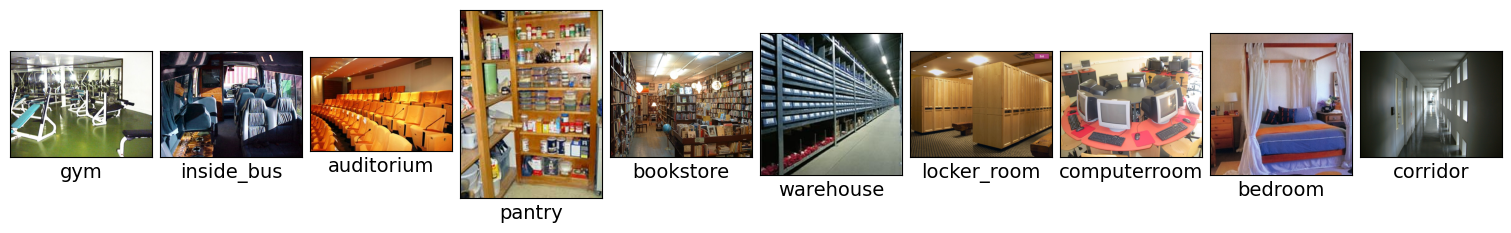

In [4]:
# Visualize 10 random images
df_sub = df.sample(n=10)
X = [cv2.imread(os.path.join(data_dir, filename)) for filename in df_sub['Filename'].to_numpy()]
y = df_sub['Class_name'].to_numpy()
fig, axes = plt.subplots(1, 10,  figsize=(15,45), layout='constrained')
for n in range(10):
    img_rgb = cv2.cvtColor(X[n], cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    axes[n].imshow(img_rgb)
    axes[n].set_xlabel(y[n], fontsize=14)
    axes[n].set_xticks(()), axes[n].set_yticks(())

## Using TensorFlow
Configuration

In [6]:
import openml_tensorflow
from keras.preprocessing.image import ImageDataGenerator

# Dataset bindings
openml_tensorflow.config.dir = data_dir
openml_tensorflow.config.x_col = "Filename"
openml_tensorflow.config.y_col = 'Class_encoded'
openml_tensorflow.config.class_mode = "categorical"

Submission code

In [7]:
def evaluate_model(model):
    # Download CV splits
    task = openml.tasks.get_task(362070)
    # Evaluate model
    run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)
    # Publish
    run = openml_tensorflow.add_onnx_to_run(run) # Optional, to inspect afterward
    run.publish()
    return run

#### Build your own model
To help you, here's a toy model - check how TensorFlow's [functional API](https://www.tensorflow.org/guide/keras/functional_api) works

In [11]:
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import Dense, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def build_toy_model():
    # Define the input
    inputs = Input(shape=(128, 128, 3))

    # A simple convolutional layer, GAP, and output layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = GlobalAveragePooling2D()(x)
    output = Dense(67, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=inputs, outputs=output)
    model.compile(Adam(learning_rate=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_toy_pretrained_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(67, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_model():
    IMG_SIZE = 128
    NUM_CLASSES = 67
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze all the layers before the 75th layer (last convolutional block)
    for layer in base_model.layers[:75]:
        layer.trainable = False

    # Unfreeze the rest of the layers
    for layer in base_model.layers[75:]:
        layer.trainable = True

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add Global Average Pooling layer
    x = Dense(512, activation='relu')(x)  # Add a dense hidden layer
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)  # Add a dense hidden layer
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Add an output layer

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### Run
_You'll get a link to your experiment on OpenML (you will need to be logged in during the closed phase)._

In [18]:
# Training parameters
datagen = ImageDataGenerator(
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # do not randomly flip images vertically
    zoom_range=0.1,  # Randomly zoom image
    shear_range=0.1,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    rescale=1./255
)
openml_tensorflow.config.datagen = datagen
openml_tensorflow.config.batch_size = 32
openml_tensorflow.config.epoch = 20

# Run
run = evaluate_model(build_model()) # Replace with your model
print("Run is uploaded at https://www.openml.org/r/{}".format(run.run_id))

Found 10413 validated image filenames belonging to 67 classes.
Training (10413 samples)
Epoch 1/20
100/100 [==============================] - 14s 123ms/step - loss: 4.0412 - accuracy: 0.1616
Epoch 2/20
100/100 [==============================] - 13s 132ms/step - loss: 3.0942 - accuracy: 0.2707
Epoch 3/20
100/100 [==============================] - 12s 123ms/step - loss: 2.7634 - accuracy: 0.3181
Epoch 4/20
100/100 [==============================] - 13s 125ms/step - loss: 2.4627 - accuracy: 0.3684
Epoch 5/20
100/100 [==============================] - 13s 132ms/step - loss: 2.3492 - accuracy: 0.3981
Epoch 6/20
100/100 [==============================] - 13s 124ms/step - loss: 2.2371 - accuracy: 0.4247
Epoch 7/20
100/100 [==============================] - 12s 119ms/step - loss: 2.1582 - accuracy: 0.4328
Epoch 8/20
100/100 [==============================] - 12s 121ms/step - loss: 2.0693 - accuracy: 0.4621
Epoch 9/20
100/100 [==============================] - 12s 123ms/step - loss: 1.9837 - ac

### Exploring models (optional)
You can download your own model and visualize it with [Netron](https://netron.app/). This doesn't work in Colab, so you'll have to run this locally.

Tip: after the assignment, you can also easily visualize the models of your fellow students by simply providing a run ID.

Note: This will show an [ONNX](https://onnx.ai/onnx/intro/concepts.html) representation of your model, which shows a lot of detail. For instance: 
* A convolutional layer: Convolution operation + ReLU. 
* GAP layer: GAP operation + Squeeze (drop unused dimensions)
* Dense layer: MatMul (matrix multiplication, i.e. W*X) + Add (the biases).


In [19]:
# Installing Netron
!pip install netron --quiet
!pip install urllib3 --quiet

In [20]:
from urllib.request import urlretrieve
import netron

def visualize_model(run_id):
    run = openml.runs.get_run(run_id)
    url = 'https://api.openml.org/data/download/{}/model.onnx'.format(run.output_files['onnx_model'])
    file_path, _ = urlretrieve(url, './model.onnx')
    netron.start(file_path, browse=False)

visualize_model(run.run_id)

Serving './model.onnx' at http://localhost:8081


## Using Torch
If you used PyTorch for your assignment, you can use the code below. If you use TensorFlow, you can ignore everything below.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import openml_pytorch

# Dataset bindings
openml_pytorch.config.file_dir = data_dir
openml_pytorch.config.filename_col = "Filename"

#### Submission code
Basically the same code as for Tensorflow

In [12]:
def evaluate_torch_model(model):
    # Download CV splits
    task = openml.tasks.get_task(362070)
    # Evaluate model
    run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)
    # Publish
    run = openml_pytorch.add_onnx_to_run(run) # Optional, to inspect afterward
    run.publish()
    return run

#### Build your own model
To help you, here's a toy model. You can define anything you want (e.g. data augmentation) in the model class as usual.

_Note: The classname will be used as the architecture name on OpenML._

In [13]:
from torchvision import models

class ToyNet(nn.Module):
    def __init__(self, num_classes=67):
        super(ToyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.gap(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.fc1(x)
        return x
    
class ToyPretrainedModel(nn.Module):
    def __init__(self, num_classes=67):
        super(ToyPretrainedModel, self).__init__()
        # Load pre-trained MobileNetV2 model
        self.base_model = models.mobilenet_v2(pretrained=True).features
        # Freeze parameters in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Global Average Pooling + Output layer
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1280, num_classes),  # MobileNetV2 features output 1280 channels
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Configure and run. Training parameters are set in the config.

_You'll get a link to your experiment on OpenML (you will need to be logged in during the closed phase)._

In [ ]:
from openml import OpenMLTask

# Training parameters
openml_pytorch.config.batch_size = 32
openml_pytorch.config.epoch_count = 1

# Run
run = evaluate_torch_model(ToyNet()) # Replace with your model
print("Run is uploaded at https://www.openml.org/r/{}".format(run.run_id))

In [ ]:
# Other options to set (before calling evaluate_torch_model):
# openml_pytorch.config.criterion_gen = torch.nn.CrossEntropyLoss()
# openml_pytorch.config.optimizer_gen = optimizer_gen
#
# optimizer_gen is created as follows:
# model = ToyNet()
# def optimizer_gen(model: torch.nn.Module, _: OpenMLTask) -> torch.optim.Optimizer:
#     return torch.optim.Adam(params=model.parameters())

### Exploring models (optional)
This works the same way as shown for TensorFlow, see above.